In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Loading Word2Vec and GLoVe embeddings trained on our corpus

In [2]:
w2v_model = KeyedVectors.load_word2vec_format("w2v_embeddings.txt", binary=False)
w2v_word_to_embeddings = {word: w2v_model[word] for word in w2v_model.vocab}

In [3]:
glove_model = KeyedVectors.load_word2vec_format("glove_embeddings.txt", binary=False)
glove_word_to_embeddings = {word: glove_model[word] for word in glove_model.vocab}

In [4]:
dataset = pd.read_csv("Processed_Lyric_Dataset.csv")

In [5]:
dataset = dataset.drop(columns=["Unnamed: 0", "LyricsList"], axis=1)
dataset["LyricsList"] = dataset.apply(lambda x: eval(x['LyricProcessed']), axis=1)
dataset = dataset.drop(columns=["Artist", "Lyric", "LyricProcessed"])
dataset.head(5)

,SName,Genre,LyricsList
0,Careless Whisper,pop,"[[feel, unsure], [take, hand, lead, dance, flo..."
1,Could You Be Loved / Citação Musical do Rap: S...,pop,"[[let, fool, ya], [even, try, school, ya, oh],..."
2,Cruisin' (Part. Saulo),pop,"[[baby, let, cruise, away], [confuse, way, cle..."
3,Easy,pop,"[[know, sound, funny], [cant, stand, pain], [g..."
4,For Your Babies (The Voice cover),pop,"[[get, look], [one, hop, lad], [face, beam], [..."


In [6]:
dataset["Genre"].value_counts()

rock           29916
metal          19420
pop            12812
hip-hop        10333
indie           6020
electronic      5866
rap             4535
rnb             4271
soul            3739
punk            3440
country         3135
jazz            2969
folk            2724
alternative     1994
blues           1838
reggae          1697
Name: Genre, dtype: int64

In [7]:
genres = dataset["Genre"].unique()
genre_map = {g: i for i, g in enumerate(genres)}

# Featurizing every song by adding vectors of every word in lyrics and dividing it by the length of the song

In [8]:
w2v_training_data = []
glove_training_data = []
training_labels = []

for _, row in dataset.iterrows():
    label = row["Genre"]
    lyrics = row["LyricsList"]
    w2v_feature_vector = np.zeros((200,))
    glove_feature_vector = np.zeros((100,))
    song_length = 0
    for line in lyrics:
        song_length += len(line)
        for word in line:
            if word in w2v_word_to_embeddings:
                w2v_feature_vector += w2v_word_to_embeddings[word]
            if word in glove_word_to_embeddings:
                glove_feature_vector += glove_word_to_embeddings[word]
    if song_length == 0:
        w2v_training_data.append(w2v_feature_vector)
        glove_training_data.append(glove_feature_vector)
    else:
        w2v_training_data.append(w2v_feature_vector/song_length)
        glove_training_data.append(glove_feature_vector/song_length)
    training_labels.append(genre_map[label])

In [9]:
word2vec_X_train, word2vec_X_test, word2vec_y_train, word2vec_y_test = train_test_split(w2v_training_data, training_labels, test_size=0.2, random_state=42)

In [10]:
glove_X_train, glove_X_test, glove_y_train, glove_y_test = train_test_split(glove_training_data, training_labels, test_size=0.2, random_state=42)

# Baseline Gaussian Naive Bayes classifier

### Word2Vec Embeddings used for training

In [11]:
word2vec_gaussian_nb = GaussianNB()

word2vec_gaussian_nb.fit(word2vec_X_train, word2vec_y_train)

GaussianNB()

In [12]:
word2vec_gaussian_y_pred = word2vec_gaussian_nb.predict(word2vec_X_test)

word2vec_gaussian_accuracy = accuracy_score(word2vec_y_test, word2vec_gaussian_y_pred)

print("Accuracy of the Gaussian Naive Bayes Classifier with Word2Vec embeddings is:", word2vec_gaussian_accuracy)

Accuracy of the Gaussian Naive Bayes Classifier with Word2Vec embeddings is: 0.26440589312178536


### GLoVe Embeddings used for Training

In [13]:
glove_gaussian_nb = GaussianNB()

glove_gaussian_nb.fit(glove_X_train, glove_y_train)

GaussianNB()

In [14]:
glove_y_pred = glove_gaussian_nb.predict(glove_X_test)

glove_gaussian_accuracy = accuracy_score(glove_y_test, glove_y_pred)

print("Accuracy of the Gaussian Naive Bayes Classifier with GLoVe embeddings is:", glove_gaussian_accuracy)

Accuracy of the Gaussian Naive Bayes Classifier with GLoVe embeddings is: 0.1391334670037486


# Logistic Regression Models as classifiers

In [15]:
def logistic_regression_accuracy(embeddings, penalty='no', C=1.0):

    if embeddings == 'word2vec':
        word_embeddings = w2v_training_data
    elif embeddings == "glove":
        word_embeddings = glove_training_data

    X_train, X_test, y_train, y_test = train_test_split(word_embeddings, training_labels, test_size=0.2, random_state=42)

    if penalty == 'no':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000)
    elif penalty == 'l1':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, penalty='l1', C=C, solver='saga')
    elif penalty == 'l2':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, penalty='l2', C=C)
    else:
        raise ValueError('Invalid penalty type')

    logistic_classifier.fit(X_train, y_train)

    y_pred = logistic_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy for model with", penalty, "regularization and", embeddings, "word embeddings is", accuracy)

    return accuracy

In [16]:
print("Word2Vec Embeddings")
word2vec_accuracy = logistic_regression_accuracy("word2vec")
word2vec_l1_accuracy = logistic_regression_accuracy("word2vec", penalty='l1', C=1.0)
word2vec_l2_accuracy = logistic_regression_accuracy("word2vec", penalty='l2', C=1.0)

Word2Vec Embeddings
Accuracy for model with no regularization and word2vec word embeddings is 0.4301281492459245
Accuracy for model with l1 regularization and word2vec word embeddings is 0.4307383837503269
Accuracy for model with l2 regularization and word2vec word embeddings is 0.4301281492459245


In [17]:
print("GLoVe Embeddings")
glove_accuracy = logistic_regression_accuracy("glove")
glove_l1_accuracy = logistic_regression_accuracy("glove", penalty='l1', C=1.0)
glove_l2_accuracy = logistic_regression_accuracy("glove", penalty='l2', C=1.0)

GLoVe Embeddings
Accuracy for model with no regularization and glove word embeddings is 0.32704210618080376
Accuracy for model with l1 regularization and glove word embeddings is 0.32712928253857554
Accuracy for model with l2 regularization and glove word embeddings is 0.32704210618080376


In [18]:
class LogReg(nn.Module):
    def __init__(self, embeddings = 'word2vec'):
        super().__init__()
        input_size = 200
        if embeddings != 'word2vec':
            input_size = 100
        self.layer = nn.Linear(input_size, 16)

    def forward(self, x):
        x = self.layer(x)
        return x

In [19]:
def train(model, embeddings, epochs, penalty = 'no', C=1.0, lr = 0.01, verbose=False):
    loss_func = nn.CrossEntropyLoss()
    if embeddings == 'word2vec':
        word_embeddings = w2v_training_data
    elif embeddings == "glove":
        word_embeddings = glove_training_data

    X_train, X_test, y_train, y_test = train_test_split(word_embeddings, training_labels, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    if penalty == 'no':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif penalty == 'l1':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=C, momentum=0.9)
    elif penalty == 'l2':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=C)
    else:
        raise ValueError('Invalid penalty type')

    train_losses = []
    val_losses = []
    best_accuracy = 0.0
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_func(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            loss = loss_func(outputs, y_test)
            val_losses.append(loss.item())

        # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == y_test).sum().item() / len(y_test)
            if accuracy > best_accuracy:
                best_accuracy = accuracy

        if verbose:
            if int(epochs//3) == 33:
                print("33% training done.")
            elif int(epochs//6) == 66:
                print("66% training done.")

    return train_losses, val_losses, best_accuracy

In [20]:
def visualize_validation_training_loss(training_loss, validation_loss):
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

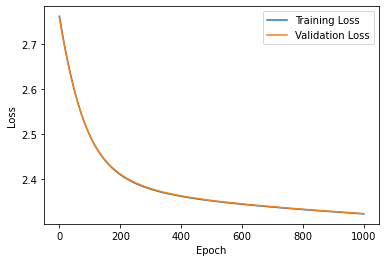

0.2604829570220556

In [21]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy = train(w2v_logistic, 'word2vec', 1000)
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
best_accuracy

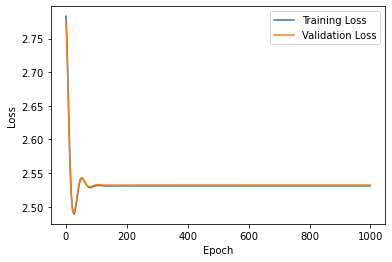

0.2620957196408334

In [22]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy = train(w2v_logistic, 'word2vec', 1000, penalty='l1')
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
best_accuracy

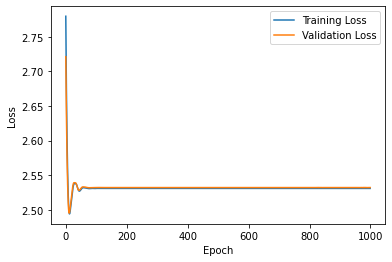

0.2577804899311307

In [23]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy = train(w2v_logistic, 'word2vec', 1000, penalty='l2')
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
best_accuracy

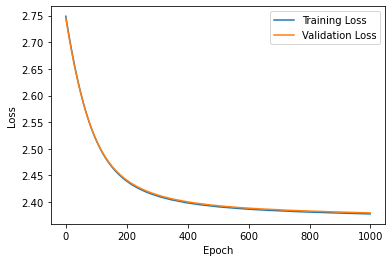

0.2583471362566472

In [24]:
glove_logistic = LogReg(embeddings='glove')
glove_training_loss, glove_testing_loss, best_accuracy = train(glove_logistic, 'glove', 1000)
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
best_accuracy

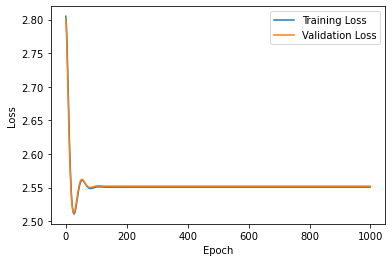

0.25782407811001656

In [25]:
glove_logistic = LogReg(embeddings='glove')
glove_training_loss, glove_testing_loss, best_accuracy = train(glove_logistic, 'glove', 1000, penalty='l1')
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
best_accuracy

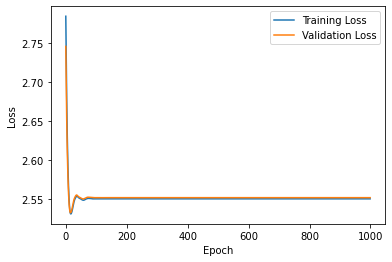

0.2598727225176532

In [26]:
glove_logistic = LogReg(embeddings='glove')
glove_training_loss, glove_testing_loss, best_accuracy = train(glove_logistic, 'glove', 1000, penalty='l2')
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
best_accuracy